In [0]:
%matplotlib inline
!pip install livelossplot

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform
from tqdm import tqdm_notebook
from livelossplot import PlotLosses
from datetime import datetime
# Ignore warnings
import warnings,os
warnings.filterwarnings("ignore")


In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
from google.colab import drive
drive.mount('/Bengali_Dataset',force_remount=True)

Mounted at /Bengali_Dataset


In [0]:
!ls "/Bengali_Dataset/My Drive/Bengali"


images_unzipped.csv	model.pth      train.csv     train.zip
images_unzipped.gsheet	pytorch.ipynb  train_subset


In [0]:
root_path = '/Bengali_Dataset/My Drive/Bengali/'
print(type(root_path))

<class 'str'>


In [0]:
df=pd.read_csv(root_path + "train.csv")
df.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


In [0]:
label1_num = df['grapheme_root'].max()+1
label2_num = df['vowel_diacritic'].max()+1
label3_num = df['consonant_diacritic'].max()+1

print(label1_num)
print(label2_num)
print(label3_num)

168
11
7


In [0]:
mean = 0.06922848809290576
std = 0.20515700083327537

In [0]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors. Also normalize the images"""

    def __call__(self, sample):
        image, labels = sample['image'], sample['labels']
        image = (image - 255)/255
        image = (image - mean)/std
        image = torch.from_numpy(image)
        
        image = image[np.newaxis,...]
        return {'image': image,
                'labels': torch.from_numpy(np.array(labels))}

In [0]:
csv_dir="/Bengali_Dataset/My Drive/Bengali/train.csv"
root_dir=root_path

In [0]:
class bengalidataset(Dataset):
    def __init__(self,csv_dir,root_dir,transform=None):
        self.csv_dir = csv_dir
        self.olddata = pd.read_csv(csv_dir)
        self.data = []
        self.root_dir = root_dir
        for index in range(len(self.olddata)):
          # print(index)
          filename= f'{self.root_dir}train_subset/train/{self.olddata.iloc[index,0]}.png'
          if(not os.path.exists(filename)): continue
          
          self.data.append(list(self.olddata.iloc[index]))

        self.data = pd.DataFrame(self.data,columns=['Image ID','label1','label2','label3','Grapheme'])

        print(self.data.shape)
        #self.data.to_csv('/Bengali_Dataset/My Drive/Bengali/images_unzipped.csv') #Don't forget to add '.csv' at the end of the path

        #print(self.data.head())

        self.transform = transform
        
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self,index=0):
        '''
        Returns image, 
            
            label is,
            
            grapheme_root          15
            vowel_diacritic         9
            consonant_diacritic     5
        '''
        
        if torch.is_tensor(index):
            index = index.tolist()
            
        
        img_name = Path(f'{self.root_dir}train_subset/train/{self.data.iloc[index,0]}.png')
        img = io.imread(img_name)
        labels = self.data.iloc[index,1:4]
        
        labels = list(labels)
        
        sample = {"image":img,"labels":labels}        
        
        
        if self.transform:
            sample = self.transform(sample)


        
        return sample

In [0]:
# Dataset creation for visualization purpose.
datast = bengalidataset(csv_dir=Path(root_path + "train.csv"),root_dir=root_path)

(1851, 5)


In [0]:
print(type(datast))


<class '__main__.bengalidataset'>


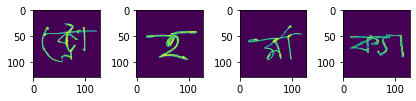

In [0]:
fig = plt.figure()

for i in range(4):
    img = datast[i]['image'] # We can access the image by index, just like I mentioned above
    ax = plt.subplot(1,4,i+1)
    plt.tight_layout()
    plt.imshow(img)
    
    if i==3:plt.show()

In [0]:
datast = bengalidataset(csv_dir=Path(root_path + "train.csv"),root_dir=root_path,transform=transforms.Compose([ToTensor()]))
print(type(datast))

(1851, 5)
<class '__main__.bengalidataset'>


In [0]:
bs=256

In [0]:
dataset_loader = torch.utils.data.DataLoader(datast,
                                             batch_size=bs, shuffle=True,
                                             num_workers=1)

In [0]:
class NNet(nn.Module):
    def __init__(self,label1_num,label2_num,label3_num):
        super(NNet,self).__init__()
        self.conv1 = nn.Conv2d(1,32,5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32,64,5)
        self.conv3 = nn.Conv2d(64,128,5)    
        self.fc1 = nn.Linear(128*12*12,label1_num)
        self.fc2 = nn.Linear(128*12*12,label2_num)
        self.fc3 = nn.Linear(128*12*12,label3_num)
        
        softmax = nn.Softmax(dim=1) 
    def forward(self,x):
        x = self.conv1(x)
        x = self.pool(x)
#         print(x.shape)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.pool(x)
#         print(x.shape)
        x = F.relu(x)
        x = self.conv3(x)
        x = self.pool(x)
        bss = x.shape[0]     
        x = x.reshape(bss,-1)
        
        l1 = self.fc1(x)
        l2 = self.fc2(x)
        l3 = self.fc3(x)
        
        #print(l1.shape) #expecting batch_size*168, 8 for no.of images and 168 is count of grapheme_roots
        #print(l2.shape) #expecting batch_zsize*11
        #print(l3.shape) #expecting batchsize*7 

        grapheme_list=l1.cpu().data.numpy().argmax(axis=1)
        vowel_list=l2.cpu().data.numpy().argmax(axis=1)
        consonant_list=l3.cpu().data.numpy().argmax(axis=1)

        oldl1=l1
        oldl2=l2
        oldl3=l3


        
        return oldl1, oldl2, oldl3,grapheme_list,vowel_list,consonant_list

In [0]:
PATH=Path(root_path + "model.pth ")

In [0]:
# train on cuda if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

nnet = NNet(label1_num,label2_num,label3_num)
#nnet.load_state_dict(torch.load('/Bengali_Dataset/My Drive/Bengali/model.pth'))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(nnet.parameters(), lr=5e-3, momentum=0.9)

nnet = nnet.to(device)

In [0]:
print(label1_num,label2_num,label3_num)

168 11 7


In [0]:
nnet

NNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=18432, out_features=168, bias=True)
  (fc2): Linear(in_features=18432, out_features=11, bias=True)
  (fc3): Linear(in_features=18432, out_features=7, bias=True)
)

In [0]:
num_epochs = 2

In [0]:
grapheme_counter=0
vowel_counter=0
consonant_counter=0
overall_counter=0

In [0]:
liveloss = PlotLosses()

# Training loop
loss_values = []
logs = {}

for epoch in range(num_epochs):
    grapheme_counter=0
    vowel_counter=0
    consonant_counter=0
    overall_counter=0
    for step,batch in tqdm_notebook(enumerate(dataset_loader)):

        # label1, label2, label3,grapheme_list,vowel_list,consonant_list = nnet(batch['image'].float().cuda())        
        try:
            label1, label2, label3,grapheme_list,vowel_list,consonant_list = nnet(batch['image'].float().cuda())
        except Exception as e:
            print('working??',e)
            continue

        labels = batch['labels'].cuda()
        targ_label1 = labels[:,0]
        targ_label2 = labels[:,1]
        targ_label3 = labels[:,2]
        

        loss1 = criterion(label1,targ_label1)
        loss2 = criterion(label2,targ_label2)    
        loss3 = criterion(label3,targ_label3)


        for i in range(len(grapheme_list)):
          if grapheme_list[i] == targ_label1[i]: ##confirm if targ_label 1 has all batc size numbers of just 1
            grapheme_counter=grapheme_counter+1
          if vowel_list[i]==targ_label2[i]:
            vowel_counter=vowel_counter+1
          if consonant_list[i]==targ_label3[i]:
            consonant_counter=consonant_counter+1
          if grapheme_list[i] == targ_label1[i] and vowel_list[i]==targ_label2[i] and consonant_list[i]==targ_label3[i]:
            overall_counter=overall_counter+1

        loss = loss1 + loss2 + loss3 
        loss_values.append(loss.item())
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # Visualization data
        if step % 5 == 0:
            logs = {}
            logs['log loss'] = sum(loss_values)/len(loss_values)
            # liveloss.update(logs,step=1)
            # liveloss.draw()
           # loss_values = []
            if step>0:
              print(f"epoch is..{epoch} and step is..{step}")
              print(f"count of images..{step*bs}")
              print(f"grapheme counter..{grapheme_counter}")
              print(f"**................................**")
              print(f"grapheme_counter----  {(grapheme_counter/(step*bs))*100}%")
              print(f"vowel_counter----  {(vowel_counter/(step*bs))*100}%")
              print(f"consonant_counter----  {(consonant_counter/(step*bs))*100}%")
              print(f"overall_counter----  {(overall_counter/(step*bs))*100}%")


epoch is..0 and step is..5
count of images..1280
grapheme counter..27
**................................**
grapheme_counter----  2.109375%
vowel_counter----  25.390625%
consonant_counter----  62.5%
overall_counter----  0.0%


epoch is..1 and step is..5
count of images..1280
grapheme counter..53
**................................**
grapheme_counter----  4.140625%
vowel_counter----  46.09375%
consonant_counter----  74.84375%
overall_counter----  0.15625%


In [0]:
print(grapheme_counter)
print(epoch)
print(step)

NameError: ignored